In [49]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import GridSearchCV


In [50]:
data = pd.read_csv('IS4242 Data.csv')
data.shape

(655, 45)

In [51]:
data

,speech,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,...,chroma_1,chroma_8,spectral_1,spectral_2,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,../data\Angry_Female\anger_xn_1.wav,angry,-494.27545,134.56302,-25.692625,44.874004,-6.713496,-20.871096,13.515034,-5.726561,...,0.402734,0.503801,31.923484,17.956310,0.059400,0.014392,0.118363,0.036899,0.047293,-0.028096
1,../data\Angry_Female\anger_xn_10.wav,angry,-489.23740,95.24146,-6.124708,45.021780,-1.017477,-12.822159,15.770240,-8.326754,...,0.409627,0.526004,29.469380,16.135760,-0.010318,0.051561,0.045706,-0.027530,-0.004011,-0.008055
2,../data\Angry_Female\anger_xn_11.wav,angry,-520.55280,101.38983,-10.185467,41.562035,3.115262,-10.974776,11.411966,-1.241703,...,0.627573,0.540234,28.944638,13.118379,0.005677,-0.002739,0.116942,0.065897,-0.005532,-0.037391
3,../data\Angry_Female\anger_xn_12.wav,angry,-490.04434,127.46854,-25.104696,38.669410,-12.717003,-19.364574,20.204561,-6.294515,...,0.454550,0.499391,29.633752,15.092322,0.042003,0.046887,0.056951,0.035294,0.028878,-0.020695
4,../data\Angry_Female\anger_xn_13.wav,angry,-475.49997,120.51346,-31.929777,47.917557,-6.103209,-19.414783,9.694456,-2.136703,...,0.350280,0.550284,30.638892,15.346131,0.019974,0.033962,0.098241,0.080186,0.020042,-0.017513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,../data\Sad_Male\sad_xnm_37.wav,sad,-490.72974,173.60327,-11.465406,29.555487,7.677331,-8.637028,11.260617,1.238469,...,0.772727,0.334293,30.969400,12.342257,0.028993,0.021728,0.054774,0.085559,-0.019411,0.019814
651,../data\Sad_Male\sad_xnm_38.wav,sad,-499.82620,175.99588,-11.179701,22.779234,11.862212,-5.281943,4.698610,-0.047143,...,0.769216,0.377823,30.324798,15.892613,-0.013732,0.063382,-0.078476,0.130113,0.015439,0.040597
652,../data\Sad_Male\sad_xnm_39.wav,sad,-486.96870,185.71103,-18.759544,31.140142,-6.757489,-9.042919,14.109140,4.078134,...,0.704893,0.421041,28.897544,13.578130,0.004008,-0.000080,-0.057926,0.008501,-0.020336,-0.007781
653,../data\Sad_Male\sad_xnm_40.wav,sad,-502.96518,201.11638,-29.716246,26.259360,-1.757502,-9.877089,17.492464,-2.174063,...,0.714081,0.408348,29.367230,13.066962,-0.016031,0.040484,0.023422,0.043512,0.008923,0.014980


# Train Test Split

In [52]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = data.drop(columns=["label", "speech"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Evaluation Function

In [53]:
# Evaluation Method
def evaluate_model(model, model_name, x_test, y_test):
    # Binarize the output
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)

    # Predict probabilities for each class
    y_probs = model.predict_proba(x_test)

    # Compute ROC curve and ROC area for each class
    n_classes = y_test_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for a specific class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Additional evaluation metrics
    y_pred = model.predict(x_test)
    print(f'Accuracy Score for {model_name}: {model.score(x_test, y_test)}')
    print(f'Precision Score (weighted) for {model_name}: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall Score (weighted) for {model_name}: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1 Score (weighted) for {model_name}: {f1_score(y_test, y_pred, average="weighted")}')
    print()
    print(f'Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}')


# Logistic Regression

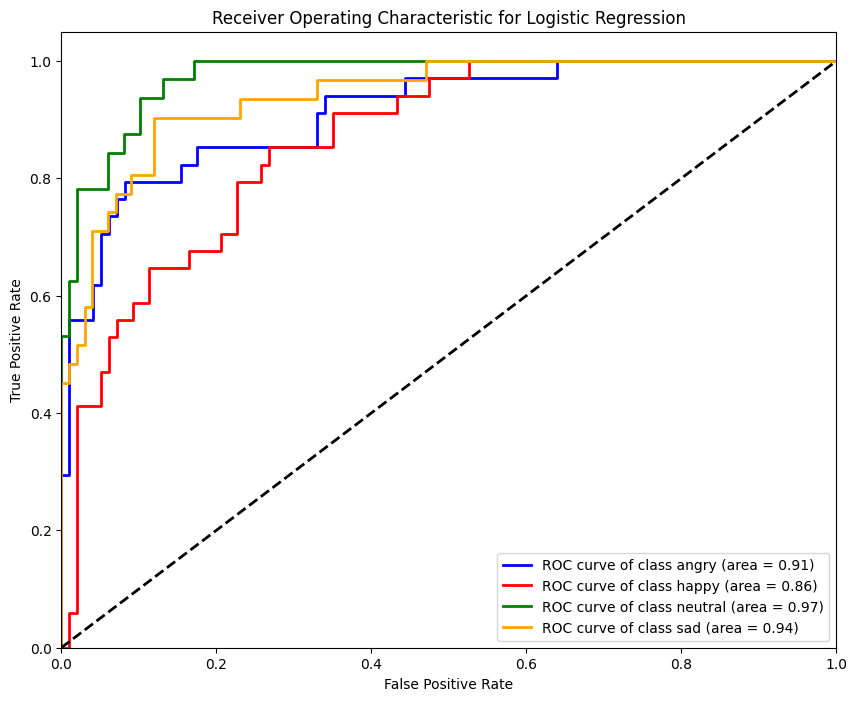

Accuracy Score for Logistic Regression: 0.7404580152671756
Precision Score (weighted) for Logistic Regression: 0.7391187893397616
Recall Score (weighted) for Logistic Regression: 0.7404580152671756
F1 Score (weighted) for Logistic Regression: 0.7385496183206107

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       angry       0.71      0.79      0.75        34
       happy       0.67      0.59      0.62        34
     neutral       0.81      0.81      0.81        32
         sad       0.77      0.77      0.77        31

    accuracy                           0.74       131
   macro avg       0.74      0.74      0.74       131
weighted avg       0.74      0.74      0.74       131

Confusion Matrix for Logistic Regression:
[[27  5  1  1]
 [10 20  2  2]
 [ 1  1 26  4]
 [ 0  4  3 24]]


In [54]:
# Initialize the Logistic Regression model with a random state
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
evaluate_model(logistic_model, 'Logistic Regression', X_test, y_test)

# KNN

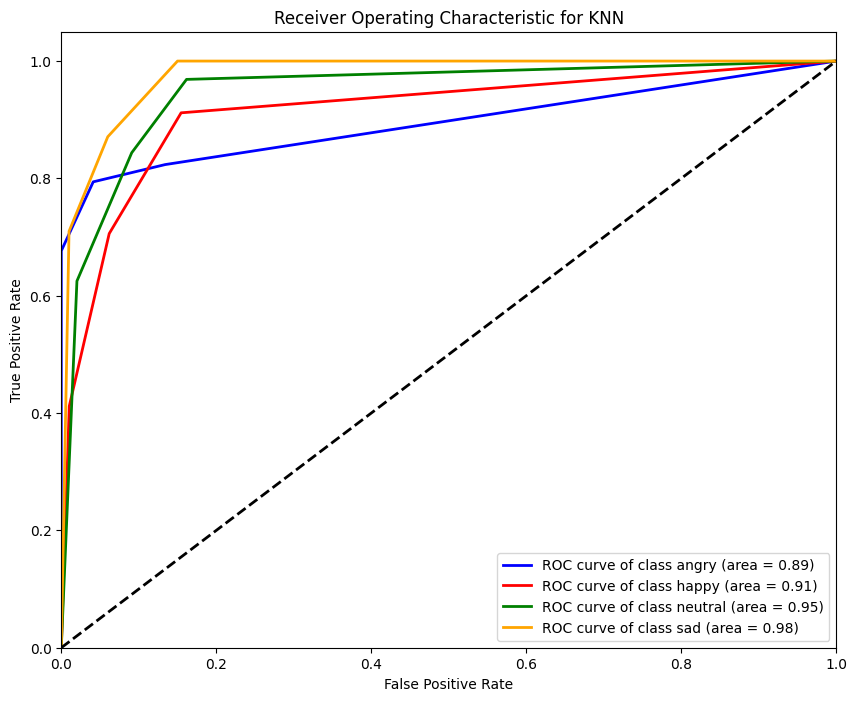

Accuracy Score for KNN: 0.8015267175572519
Precision Score (weighted) for KNN: 0.803443789035392
Recall Score (weighted) for KNN: 0.8015267175572519
F1 Score (weighted) for KNN: 0.8006579887333143

Classification Report for KNN:
              precision    recall  f1-score   support

       angry       0.84      0.79      0.82        34
       happy       0.80      0.71      0.75        34
     neutral       0.75      0.84      0.79        32
         sad       0.82      0.87      0.84        31

    accuracy                           0.80       131
   macro avg       0.80      0.80      0.80       131
weighted avg       0.80      0.80      0.80       131

Confusion Matrix for KNN:
[[27  3  4  0]
 [ 5 24  3  2]
 [ 0  1 27  4]
 [ 0  2  2 27]]


In [55]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
evaluate_model(knn_model, 'KNN', X_test, y_test)

# Random Forest

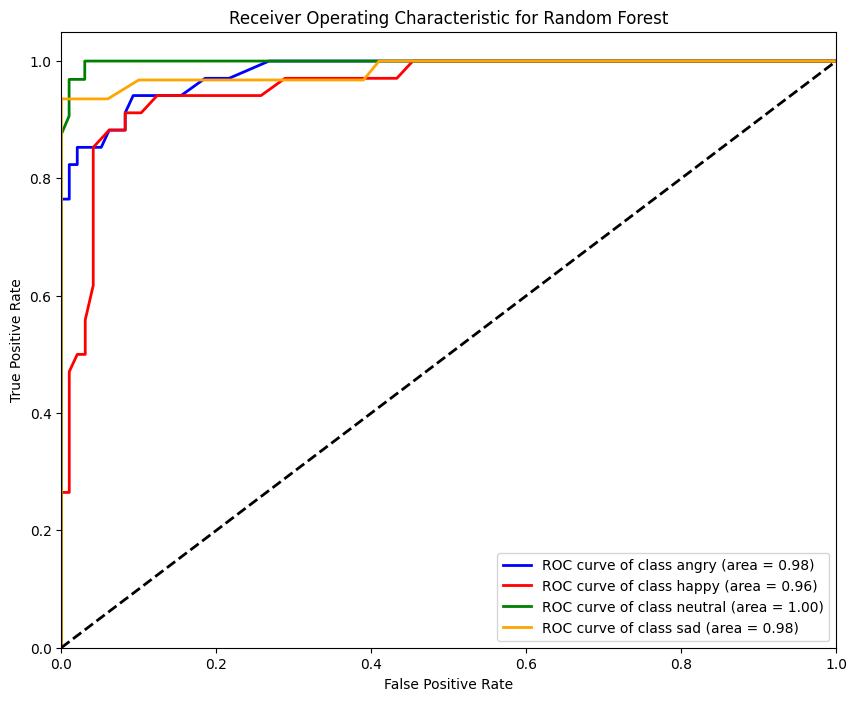

Accuracy Score for Random Forest: 0.8854961832061069
Precision Score (weighted) for Random Forest: 0.8850028386549563
Recall Score (weighted) for Random Forest: 0.8854961832061069
F1 Score (weighted) for Random Forest: 0.8837238099923327

Classification Report for Random Forest:
              precision    recall  f1-score   support

       angry       0.90      0.82      0.86        34
       happy       0.84      0.79      0.82        34
     neutral       0.89      1.00      0.94        32
         sad       0.91      0.94      0.92        31

    accuracy                           0.89       131
   macro avg       0.89      0.89      0.89       131
weighted avg       0.89      0.89      0.88       131

Confusion Matrix for Random Forest:
[[28  4  1  1]
 [ 2 27  3  2]
 [ 0  0 32  0]
 [ 1  1  0 29]]


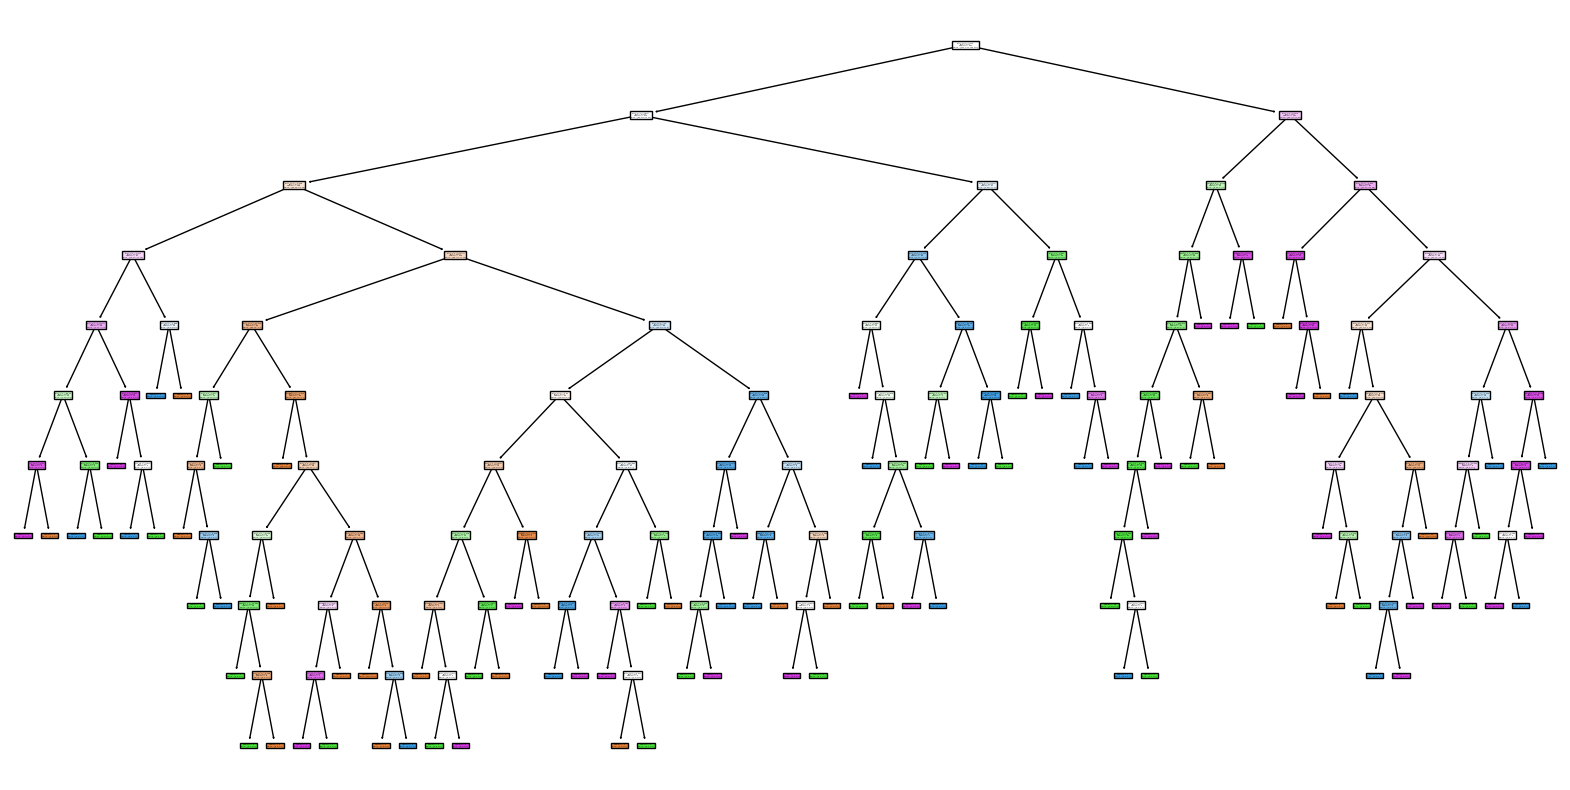

Number of trees in the forest: 100
Maximum depth of trees: 21


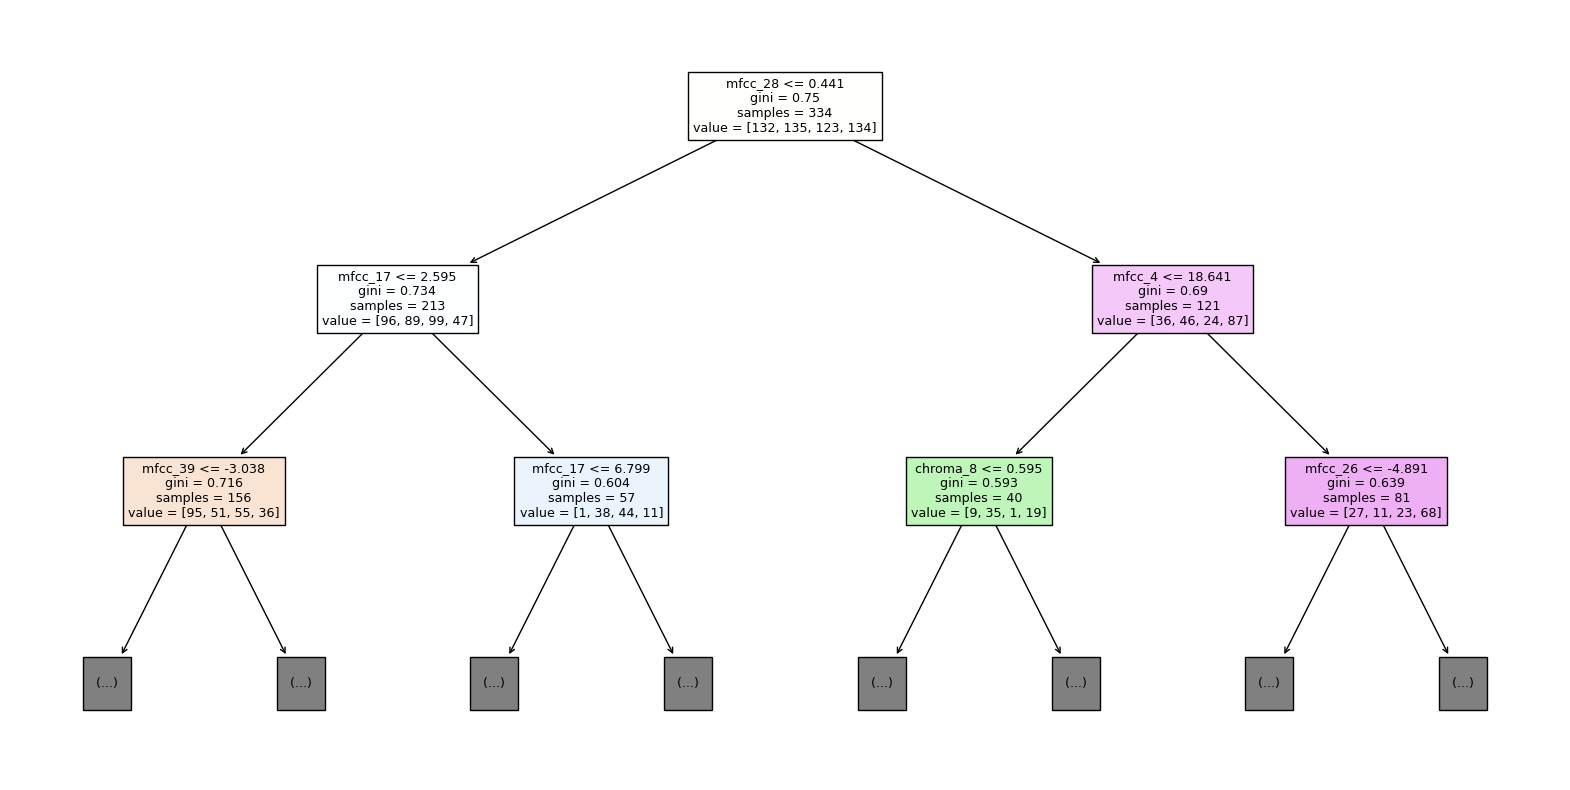

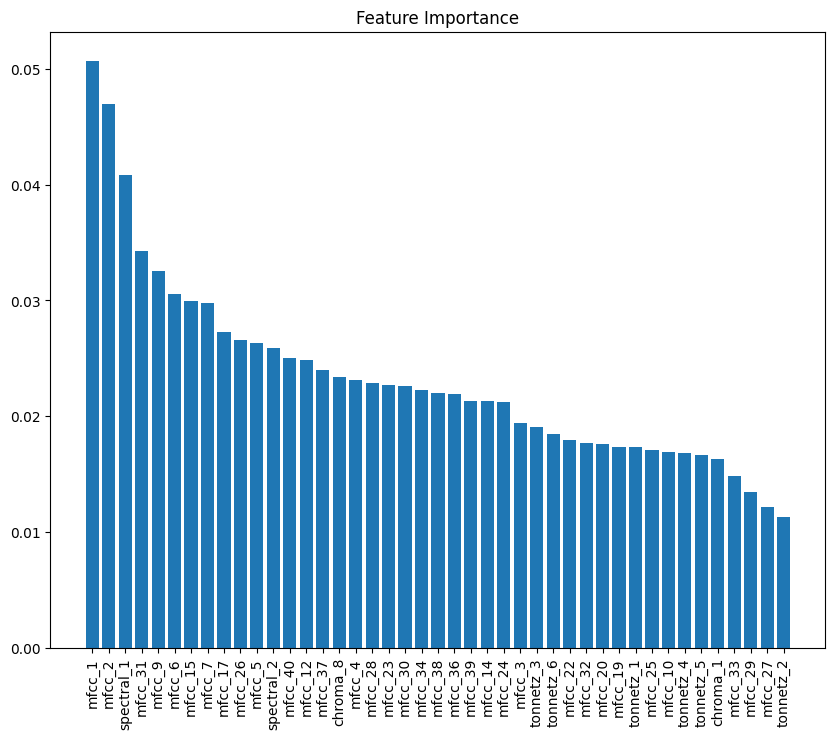

In [56]:
# Initialize the Random Forest model with a random state
# random_forest_model = RandomForestClassifier(random_state=42)

random_forest_model = RandomForestClassifier(
    # n_estimators=200,    # Use more trees
    # max_depth=10,         # Limit the depth of trees
    # min_samples_split=20, # Minimum number of samples required to split an internal node
    # min_samples_leaf=10,   # Minimum number of samples required to be at a leaf node
    # max_features='sqrt',  # Number of features to consider at each split
    # bootstrap=True,        # Use bootstrapping
    random_state=42
)


random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, "Random Forest", X_test, y_test)

# print out the tree diagram
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

# count the number of trees in the forest
n_trees = len(random_forest_model.estimators_)
print(f'Number of trees in the forest: {n_trees}')

# print the deepth of each tree
depths = [estimator.tree_.max_depth for estimator in random_forest_model.estimators_]
print(f'Maximum depth of trees: {np.max(depths)}')

# # print first 5 trees
# for i in range(5):
#     plt.figure(figsize=(20, 10))
#     plot_tree(random_forest_model.estimators_[i], feature_names=X.columns, filled=True)
#     plt.show()

# print first two levels of the first tree
plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True, max_depth=2)
plt.show()


# Feature Importance
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


